In [1]:
#importing torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
#importing other important libraries
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import timm
import pickle

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Train and Test Dataloader For training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test=datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_subset = [(img, label) for img, label in mnist if label in [0,1, 2,3,4,5,6,7,8,9]]
mnist_subset_test = [(img, label) for img, label in mnist_test if label in [0,1, 2,3,4,5,6,7,8,9]]
def rotate_image(img,ang=None):
    angles = [0, 30, 60, 90, 120,150,180,210,240,270,300,330]
    if ang!=None:
        angle=ang
    else:
        angle = random.choice(angles)
    return transforms.functional.rotate(img, angle),angle
rotated_mnist = [(img, label) for img, label in mnist_subset]
train_loader = DataLoader(rotated_mnist, batch_size=64, shuffle=True)
test_loader=DataLoader(mnist_subset_test,batch_size=64,shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.85MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
#VAE with ResNet-34 encoder
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Load Pretrained ResNet-34 from timm
        self.encoder = timm.create_model("resnet34", pretrained=True, features_only=True,in_chans=1)
        self.encoder_out_dim = 2048  # ResNet-34 outputs 512 features
        
        # Latent layers (mean & variance)
        self.fc_mu = nn.Linear(self.encoder_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_out_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        features = self.encoder(x)[-1]  
        features = features.view(features.size(0), -1)
        
        mu, logvar = self.fc_mu(features), self.fc_logvar(features)
        z = self.reparameterize(mu, logvar)
        
        x_recon = self.decoder(self.decoder_input(z).view(-1, 512, 4, 4))
        return x_recon, mu, logvar

model=VAE()

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [5]:
#optimizer and loss function
vae = model.to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")
    # recon_loss=torch.sum(-1*torch.log(torch.abs(recon_x-x)))
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return recon_loss + kl_div,recon_loss,kl_div

In [ ]:
# Training loop
epochs = 20
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for images, _ in tqdm(train_loader):
        images,_=rotate_image(images) #rotating images randomly in steps of 30
        images = images.to(device)
        optimizer.zero_grad()
        
        recon_images, mu, logvar = vae(images)
        loss,recon_loss,kl_div = loss_function(recon_images, images, mu, logvar) 
        loss.backward()  
        optimizer.step()  
        
        total_loss += loss.item()
    total_loss/=len(train_loader)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")


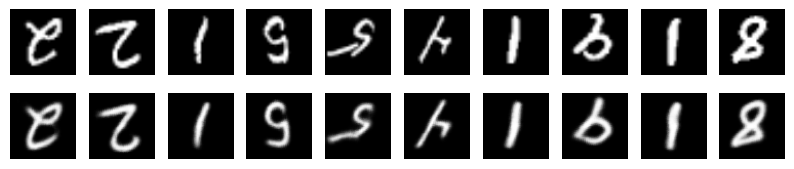

In [7]:
vae.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))  
    test_images,_=rotate_image(test_images,180)
    test_images = test_images.to(device)
    recon_images, _, _ = vae(test_images)  
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
        axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

In [6]:
model=pickle.load(open('/kaggle/input/gsoc-vae-64/VAE_64.sav','rb'))
for param in model.parameters():
    param.requires_grad = False
model=model.to(device)

In [6]:
#Multilayer Perceptron Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu=nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64)
        )
        self.logvar=nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64)
        )
    def forward(self,x,y=None):
        if y==None:
            y=x;
        return self.mu(x),self.logvar(y)
mlp=MLP()

In [7]:
def latent_vector(x):
    features=model.encoder(x)[-1]
    features = features.view(features.size(0), -1)
    mu, logvar = model.fc_mu(features), model.fc_logvar(features)
    z = model.reparameterize(mu, logvar)
    return z, mu,logvar

def decoder(mu,logvar):
    z = model.reparameterize(mu, logvar)
    x_recon = model.decoder(model.decoder_input(z).view(-1, 512, 4, 4))
    return x_recon

In [8]:
mlp = pickle.load(open("/kaggle/working/mlp.sav", "rb")).to(device)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
losses=nn.MSELoss(reduction='sum')

In [9]:
epochs = 20
mlp.train()
for epoch in range(epochs):
    total_loss = 0
    for images, _ in tqdm(train_loader):
        images,ang=rotate_image(images)
        images_rot,_=rotate_image(images,30)
        images,images_rot= images.to(device),images_rot.to(device)
        z,_,_=latent_vector(images)
        _, mu,logvar=latent_vector(images_rot)
        pred_mu,pred_logvar=mlp(z)
        loss=losses(pred_mu,mu) + losses(pred_logvar,logvar)
        random_number = random.randint(0, 11)
        for i in range(random_number):
            pred_mu,pred_logvar=mlp(pred_mu,pred_logvar)
            images_rot,_=rotate_image(images_rot,30)
            _,mu,logvar=latent_vector(images_rot)
            loss+=losses(pred_mu,mu) + losses(pred_logvar,logvar)
        # recon_image=decoder(pred_mu,pred_logvar)

        optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_loss += loss.item()
    total_loss/=len(train_loader)
    #,recon_Loss: {recon_loss:.4f}, kl_Loss: {kl_div:.4f}"
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

100%|██████████| 938/938 [01:12<00:00, 12.93it/s]


Epoch [1/20], Loss: 13236.9719


100%|██████████| 938/938 [01:10<00:00, 13.29it/s]


Epoch [2/20], Loss: 4503.0983


100%|██████████| 938/938 [01:13<00:00, 12.74it/s]


Epoch [3/20], Loss: 4342.6328


100%|██████████| 938/938 [01:12<00:00, 12.97it/s]


Epoch [4/20], Loss: 4211.0688


100%|██████████| 938/938 [01:13<00:00, 12.82it/s]


Epoch [5/20], Loss: 3964.1939


100%|██████████| 938/938 [01:13<00:00, 12.76it/s]


Epoch [6/20], Loss: 3374.4487


100%|██████████| 938/938 [01:12<00:00, 12.95it/s]


Epoch [7/20], Loss: 3323.9118


100%|██████████| 938/938 [01:14<00:00, 12.55it/s]


Epoch [8/20], Loss: 3475.4252


100%|██████████| 938/938 [01:12<00:00, 12.99it/s]


Epoch [9/20], Loss: 3311.2506


100%|██████████| 938/938 [01:11<00:00, 13.03it/s]


Epoch [10/20], Loss: 2997.9516


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


Epoch [11/20], Loss: 3569.6037


100%|██████████| 938/938 [01:12<00:00, 12.92it/s]


Epoch [12/20], Loss: 2903.0124


100%|██████████| 938/938 [01:11<00:00, 13.07it/s]


Epoch [13/20], Loss: 2747.3941


100%|██████████| 938/938 [01:11<00:00, 13.05it/s]


Epoch [14/20], Loss: 2927.0539


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


Epoch [15/20], Loss: 2615.4304


100%|██████████| 938/938 [01:12<00:00, 12.88it/s]


Epoch [16/20], Loss: 2614.0835


100%|██████████| 938/938 [01:14<00:00, 12.67it/s]


Epoch [17/20], Loss: 2871.2599


100%|██████████| 938/938 [01:11<00:00, 13.13it/s]


Epoch [18/20], Loss: 2694.5986


100%|██████████| 938/938 [01:12<00:00, 13.03it/s]


Epoch [19/20], Loss: 2636.1221


100%|██████████| 938/938 [01:12<00:00, 13.00it/s]

Epoch [20/20], Loss: 2631.4184


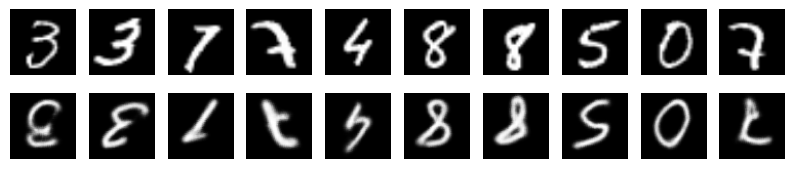

In [16]:
mlp.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))  # Get batch
    # test_images,_=rotate_image(test_images)
    test_images = test_images.to(device)# Reconstruct images
    z,_,_=latent_vector(test_images)
    mu,logvar=mlp(z)
    # recon_images=decoder(mu,logvar)
    for i in range(5):
        mu,logvar=mlp.mu(mu),mlp.logvar(logvar)
        # recon_images=decoder(mu,logvar)
    recon_images=decoder(mu,logvar)
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")  # Original
        axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap="gray")  # Reconstructed
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

In [17]:
# pickle.dump(mlp,open('/kaggle/working/mlp.sav','wb'))